In [1]:
from sklearn.datasets import make_blobs
import numpy as np
from keras.models import Sequential, Model
from keras_uncertainty.layers import StochasticDropout, SamplingSoftmax
from keras_uncertainty.models import DisentangledStochasticClassifier, StochasticClassifier
from keras.layers import Dense, Input, Dropout
from keras_uncertainty.utils import numpy_entropy


Keras Uncertainty will use standalone Keras backend

In [34]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=[[-1.5, 1.5],[0, -1.5]], random_state=0)
BATCH_SIZE = 256
NUM_SAMPLES = 100

In [35]:
def uncertainty(probs):
    return numpy_entropy(probs, axis=-1)


def two_head_model(trunk_model, num_classes=2, num_samples=100):
    inp = Input(shape=(2,))
    x = trunk_model(inp)
    logit_mean = Dense(num_classes, activation="linear")(x)
    logit_var = Dense(num_classes, activation="softplus")(x)
    probs = SamplingSoftmax(num_samples=num_samples, variance_type="linear_std")([logit_mean, logit_var])
    
    train_model = Model(inp, probs, name="train_model")
    pred_model = Model(inp, [logit_mean, logit_var], name="pred_model")

    train_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return train_model, pred_model


def train_stochastic_model(trunk_model, x_train, y_train, epochs=300):
    train_model, pred_model = two_head_model(trunk_model)
    train_model.fit(x_train, y_train, verbose=2, epochs=epochs, batch_size=BATCH_SIZE)

    fin_model = DisentangledStochasticClassifier(pred_model, epi_num_samples=NUM_SAMPLES)

    return fin_model

def eval_disentangled_model(disentangled_model, samples):
    pred_mean, pred_ale_std, pred_epi_std = disentangled_model.predict(samples, batch_size=BATCH_SIZE)
    ale_entropy = uncertainty(pred_ale_std)
    epi_entropy = uncertainty(pred_epi_std)

    return ale_entropy, epi_entropy

def train_disentangling_dropout_model(x_train, y_train, prob=0.5):
    model = Sequential()
    model.add(Dense(32, activation="relu", input_shape=(2,)))
    model.add(StochasticDropout(prob))
    model.add(Dense(32, activation="relu"))
    model.add(StochasticDropout(prob))

    return train_stochastic_model(model, x_train, y_train, epochs=50)

In [36]:
disentangled_dropout_model = train_disentangling_dropout_model(X, y)

Epoch 1/50
4/4 - 0s - loss: 0.6581 - accuracy: 0.6170 - 338ms/epoch - 85ms/step
Epoch 2/50
4/4 - 0s - loss: 0.6036 - accuracy: 0.6760 - 14ms/epoch - 4ms/step
Epoch 3/50
4/4 - 0s - loss: 0.5679 - accuracy: 0.6920 - 13ms/epoch - 3ms/step
Epoch 4/50
4/4 - 0s - loss: 0.5140 - accuracy: 0.7760 - 14ms/epoch - 4ms/step
Epoch 5/50
4/4 - 0s - loss: 0.4731 - accuracy: 0.8110 - 14ms/epoch - 3ms/step
Epoch 6/50
4/4 - 0s - loss: 0.4525 - accuracy: 0.8100 - 12ms/epoch - 3ms/step
Epoch 7/50
4/4 - 0s - loss: 0.4334 - accuracy: 0.8180 - 11ms/epoch - 3ms/step
Epoch 8/50
4/4 - 0s - loss: 0.3975 - accuracy: 0.8630 - 14ms/epoch - 3ms/step
Epoch 9/50
4/4 - 0s - loss: 0.3719 - accuracy: 0.8760 - 13ms/epoch - 3ms/step
Epoch 10/50
4/4 - 0s - loss: 0.3508 - accuracy: 0.8830 - 12ms/epoch - 3ms/step
Epoch 11/50
4/4 - 0s - loss: 0.3463 - accuracy: 0.8910 - 12ms/epoch - 3ms/step
Epoch 12/50
4/4 - 0s - loss: 0.3101 - accuracy: 0.9010 - 12ms/epoch - 3ms/step
Epoch 13/50
4/4 - 0s - loss: 0.2925 - accuracy: 0.9050 - 13

In [117]:
X_3class, y_3class = make_blobs(n_samples=1000, n_features=2, centers=[[-1.5, 1.5],[0, -1.5], [9, 8.0]], random_state=0)


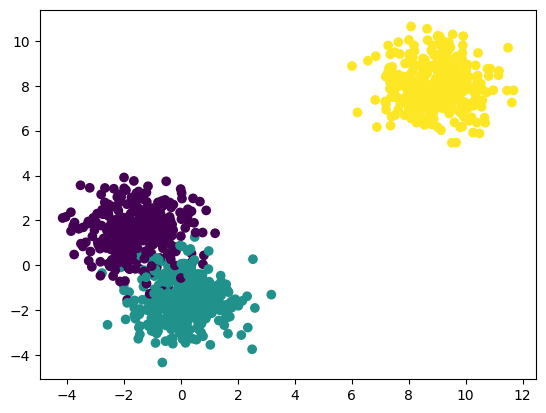

In [118]:
import matplotlib.pyplot as plt

plt.scatter(X_3class[:,0], X_3class[:,1], c=y_3class)

In [119]:
ale_entropy, epi_entropy = eval_disentangled_model(disentangled_dropout_model, X_3class)

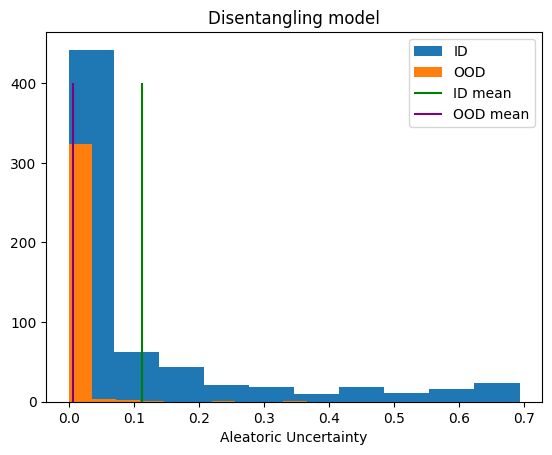

In [136]:
plt.hist(ale_entropy[y_3class != 2], label="ID")
plt.hist(ale_entropy[y_3class == 2], label="OOD")
plt.vlines(ale_entropy[y_3class != 2].mean(), ymin=0, ymax=400, label="ID mean", color='green')
plt.vlines(ale_entropy[y_3class == 2].mean(), ymin=0, ymax=400, label="OOD mean", color='purple')
plt.xlabel("Aleatoric Uncertainty")
plt.title("Disentangling model")

plt.legend()

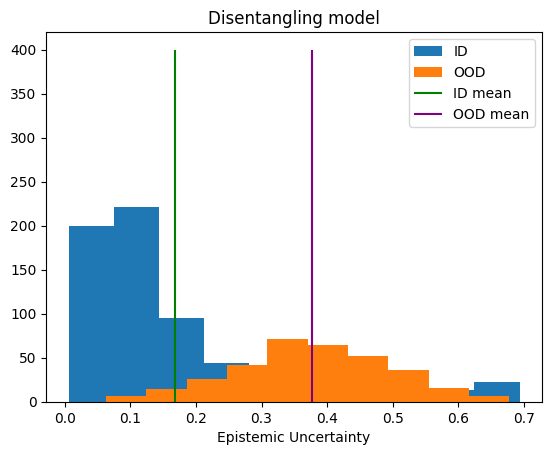

In [135]:
plt.hist(epi_entropy[y_3class != 2], label="ID")
plt.hist(epi_entropy[y_3class == 2], label="OOD")
plt.vlines(epi_entropy[y_3class != 2].mean(), ymin=0, ymax=400, label="ID mean", color='green')
plt.vlines(epi_entropy[y_3class == 2].mean(), ymin=0, ymax=400, label="OOD mean", color='purple')
plt.xlabel("Epistemic Uncertainty")
plt.title("Disentangling model")
plt.legend()

In [134]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_3class == 2, ale_entropy) 

0.11791401596499046

In [123]:
roc_auc_score(y_3class == 2, epi_entropy)

0.8649278964121543

In [124]:
def train_entropy_dropout_model(x_train, y_train, prob=0.5):
    model = Sequential()
    model.add(Dense(32, activation="relu", input_shape=(2,)))
    model.add(Dropout(prob))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(prob))
    model.add(Dense(2, activation="softmax"))
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    model.fit(x_train, y_train, verbose=2, epochs=50)
    
    mc_model = StochasticClassifier(model)

    return mc_model
entropy_model = train_entropy_dropout_model(X, y)

Epoch 1/50
32/32 - 0s - loss: 0.7397 - accuracy: 0.5750 - 190ms/epoch - 6ms/step
Epoch 2/50
32/32 - 0s - loss: 0.4367 - accuracy: 0.8120 - 39ms/epoch - 1ms/step
Epoch 3/50
32/32 - 0s - loss: 0.3377 - accuracy: 0.8740 - 39ms/epoch - 1ms/step
Epoch 4/50
32/32 - 0s - loss: 0.2456 - accuracy: 0.9190 - 33ms/epoch - 1ms/step
Epoch 5/50
32/32 - 0s - loss: 0.2198 - accuracy: 0.9190 - 33ms/epoch - 1ms/step
Epoch 6/50
32/32 - 0s - loss: 0.1993 - accuracy: 0.9270 - 37ms/epoch - 1ms/step
Epoch 7/50
32/32 - 0s - loss: 0.1883 - accuracy: 0.9280 - 37ms/epoch - 1ms/step
Epoch 8/50
32/32 - 0s - loss: 0.1895 - accuracy: 0.9300 - 27ms/epoch - 848us/step
Epoch 9/50
32/32 - 0s - loss: 0.1704 - accuracy: 0.9350 - 35ms/epoch - 1ms/step
Epoch 10/50
32/32 - 0s - loss: 0.1788 - accuracy: 0.9310 - 37ms/epoch - 1ms/step
Epoch 11/50
32/32 - 0s - loss: 0.1717 - accuracy: 0.9390 - 37ms/epoch - 1ms/step
Epoch 12/50
32/32 - 0s - loss: 0.1639 - accuracy: 0.9450 - 39ms/epoch - 1ms/step
Epoch 13/50
32/32 - 0s - loss: 0.1

In [125]:
individual_predictions = entropy_model.predict_samples(X_3class, num_samples=NUM_SAMPLES)


In [126]:
def predictive_entropy(probs, axis=-1, eps=1e-6):
    probs = np.mean(probs, axis=0)
    return -np.sum(probs * np.log(probs + eps), axis=axis)

def expected_entropy(probs, eps=1e-6):
  return -np.mean((probs * np.log(probs + eps)).sum(axis=-1), axis=0)

def mutual_information(probs):
  return predictive_entropy(probs) - expected_entropy(probs)


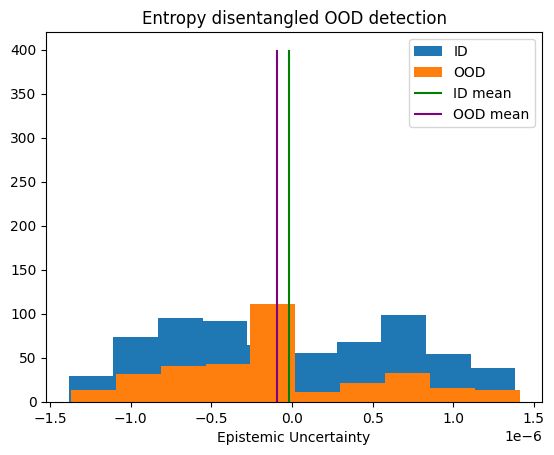

In [127]:
mutual_info = mutual_information(individual_predictions)
expect_entro = expected_entropy(individual_predictions)

plt.hist(mutual_info[y_3class != 2], label="ID")
plt.hist(mutual_info[y_3class == 2], label="OOD")
plt.vlines(mutual_info[y_3class != 2].mean(), ymin=0, ymax=400, label="ID mean", color='green')
plt.vlines(mutual_info[y_3class == 2].mean(), ymin=0, ymax=400, label="OOD mean", color='purple')
plt.xlabel("Epistemic Uncertainty")
plt.title("Entropy disentangled OOD detection")
plt.legend()

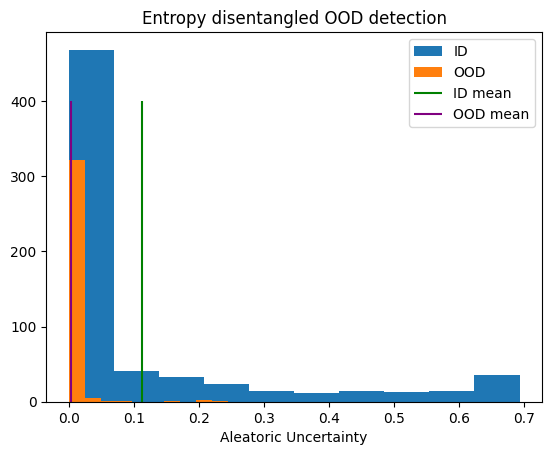

In [128]:
plt.hist(expect_entro[y_3class != 2], label="ID")
plt.hist(expect_entro[y_3class == 2], label="OOD")
plt.vlines(expect_entro[y_3class != 2].mean(), ymin=0, ymax=400, label="ID mean", color='green')
plt.vlines(expect_entro[y_3class == 2].mean(), ymin=0, ymax=400, label="OOD mean", color='purple')
plt.xlabel("Aleatoric Uncertainty")
plt.title("Entropy disentangled OOD detection")
plt.legend()

In [131]:
roc_auc_score(y_3class == 2, expect_entro)

0.09006757882320102

In [132]:
roc_auc_score(y_3class == 2, mutual_info)

0.4795575185380283